## 수정사항
#### 2021.06.06
* T_ej는 마지막 조인트 각도에 영향을 받음, 하지만 Q는 unkown이므로 특정하는게 불가능, T_ee로 전부 새로 학습할 것.

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import os
import shutil
import random
PROJ_DIR = os.environ["RNB_PLANNING_DIR"]
os.chdir(os.path.join(PROJ_DIR, "src"))

from pkg.utils.utils_python3 import *
DATA_PATH = os.path.join(PROJ_DIR, "data")
LAT_DATA_PATH = os.path.join(DATA_PATH, "latticized")
MODEL_PATH = os.path.join(PROJ_DIR, "model")
LAT_MODEL_PATH = os.path.join(MODEL_PATH,"latticized")
try_mkdir(MODEL_PATH)
try_mkdir(LAT_MODEL_PATH)
GRASP_FOLDER = "grasp"
ARM10_FOLDER = "arm_10"
ARM05_FOLDER = "arm_05"
FULLS_FOLDER = "full_scene"

In [3]:
ROBOT_TYPE_NAME="indy7"
ROBOT_DATA_ROOT = os.path.join(LAT_DATA_PATH, ROBOT_TYPE_NAME)
ROBOT_DATA_ROOT_FAILS = ROBOT_DATA_ROOT+"-failmore"
# ROBOT_DATA_ROOT = LAT_DATA_PATH
ROBOT_MODEL_ROOT =  os.path.join(LAT_MODEL_PATH, ROBOT_TYPE_NAME)
ARM_FOLDER = ARM10_FOLDER

In [5]:
dataset_list = sorted(os.listdir(ROBOT_DATA_ROOT))
DATASET_TRAIN = dataset_list[:10]
DATASET_TEST = dataset_list[10:]
print(DATASET_TRAIN)
print(DATASET_TEST)

dataset_list_fails = sorted([folder for folder in os.listdir(ROBOT_DATA_ROOT_FAILS) if not folder.startswith(".")])
DATASET_TRAIN_FAILS = dataset_list_fails[:10]
DATASET_TEST_FAILS = dataset_list_fails[10:15]
print(DATASET_TRAIN_FAILS)
print(DATASET_TEST_FAILS)

['20210214-232708', '20210215-041031', '20210215-085110', '20210215-133753', '20210215-184319', '20210216-005455', '20210216-054418', '20210216-104554', '20210216-152114', '20210216-201729']
['20210217-010926', '20210217-063641', '20210217-113319', '20210217-162106', '20210217-205606', '20210608-122742', '20210608-194120']
['20210607-155241', '20210607-161407', '20210607-163215', '20210607-165616', '20210607-171344', '20210607-173927', '20210607-175629', '20210607-181751', '20210607-183958', '20210607-190513']
['20210607-192529', '20210607-194820', '20210607-200835', '20210607-202843', '20210607-205048']


In [8]:
GRASP_SHAPE = (20,20,20)
ARM_SHAPE = (20,20,20)
RH_MASK_SIZE = 512
RH_MASK_STEP = 64

data_pairs_train_succ = []
for dataset in DATASET_TRAIN:
    file_list = sorted(os.listdir(os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER)))
    for file in file_list:
        data_pairs_train_succ.append((os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER, file), 
                                 os.path.join(ROBOT_DATA_ROOT, dataset, ARM_FOLDER, file)))
print("train set: {}".format(len(data_pairs_train_succ)))        
        
        
data_pairs_test_succ = []
for dataset in DATASET_TEST[-1:]:
    file_list = sorted(os.listdir(os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER)))
    for file in file_list:
        data_pairs_test_succ.append((os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER, file), 
                                 os.path.join(ROBOT_DATA_ROOT, dataset, ARM_FOLDER, file)))
print("test set: {}".format(len(data_pairs_test_succ)))        

data_pairs_train_fails = []
for dataset in DATASET_TRAIN_FAILS:
    file_list = sorted(os.listdir(os.path.join(ROBOT_DATA_ROOT_FAILS, dataset, GRASP_FOLDER)))
    for file in file_list:
        data_pairs_train_fails.append((os.path.join(ROBOT_DATA_ROOT_FAILS, dataset, GRASP_FOLDER, file), 
                                 os.path.join(ROBOT_DATA_ROOT_FAILS, dataset, ARM_FOLDER, file)))
print("train fail set: {}".format(len(data_pairs_train_fails)))        
        
        
data_pairs_test_fails = []
for dataset in DATASET_TEST_FAILS:
    file_list = sorted(os.listdir(os.path.join(ROBOT_DATA_ROOT_FAILS, dataset, GRASP_FOLDER)))
    for file in file_list:
        data_pairs_test_fails.append((os.path.join(ROBOT_DATA_ROOT_FAILS, dataset, GRASP_FOLDER, file), 
                                 os.path.join(ROBOT_DATA_ROOT_FAILS, dataset, ARM_FOLDER, file)))
print("test fail set: {}".format(len(data_pairs_test_fails)))        

train set: 10022
test set: 188
train fail set: 10044
test fail set: 5016


In [9]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def div_r_gaussian(r_val):
    return gaussian(r_val, np.arange(0.1,1.2, 0.05),0.1)

def div_h_gaussian(h_val):
    return gaussian(h_val, np.arange(-0.5,1.1, 0.05),0.1)

def load_data(data_pair):
    grasp_data = load_pickle(data_pair[0])
    arm_data = load_pickle(data_pair[1])
    grasp_obj_idx = grasp_data[b'obj']
    grasp_tar_idx = grasp_data[b'tar']
    grasp_tool_idx = grasp_data[b'tool']
    arm_tar_idx = arm_data[b'tar']
    Tee = grasp_data[b'T_end_effector']
    Tej = grasp_data[b'T_end_joint']
    Tref_base = grasp_data[b'Tref_base']
    reach_lb = grasp_data[b'reach']
    retrieve_lb = grasp_data[b'retrieve']
    r, th, h = cart2cyl(*Tee[:3,3])
#     r_ej, th_ej, h_ej = cart2cyl(*Tej[:3,3])  # not exact value, no use
    r_mask = div_r_gaussian(r)
    h_mask = div_h_gaussian(h)
    rh_mask = np.concatenate([r_mask, h_mask])
#     rh_mask = np.array([r, h, r_ej, h_ej])
    # r_ej_list.append(r_ej)
    # h_ej_list.append(h_ej)
    # reach_lb_list.append(reach_lb)
#     Tref = SE3(Rot_axis(3, th), Tee[:3,3])
    grasp_tool_img = np.zeros(GRASP_SHAPE)
    grasp_tar_img = np.zeros(GRASP_SHAPE)
    grasp_obj_img = np.zeros(GRASP_SHAPE)
    grasp_tool_img[np.unravel_index(grasp_tool_idx, shape=GRASP_SHAPE)] = 1
    grasp_tar_img[np.unravel_index(grasp_tar_idx, shape=GRASP_SHAPE)] = 1
    grasp_obj_img[np.unravel_index(grasp_obj_idx, shape=GRASP_SHAPE)] = 1
    arm_img = np.zeros(ARM_SHAPE+(1,))
    arm_img[np.unravel_index(arm_tar_idx, shape=ARM_SHAPE)] = 1
    grasp_img = np.stack([grasp_tool_img, grasp_obj_img, grasp_tar_img], axis=-1)
#     grasp_img = np.stack([grasp_tool_img, np.logical_or(grasp_obj_img, grasp_tar_img)], axis=-1)
#     grasp_img = np.stack([grasp_tool_img, grasp_tar_img], axis=-1)
    label = np.array([reach_lb, retrieve_lb])
    return grasp_img, arm_img, rh_mask, label

In [10]:
r_list = []
h_list = []
rmat = []
hmat = []
for data_pairs in data_pairs_test_succ:
    grasp_data = load_pickle(data_pairs[0])
    Tref_base = grasp_data[b'Tref_base']
    Tee = grasp_data[b'T_end_effector']
    r, th, h = cart2cyl(*Tee[:3,3])
    r_list.append(r)
    h_list.append(h)
for r in sorted(r_list):
    rmat.append(div_r_gaussian(r))
for h in sorted(h_list):
    hmat.append(div_h_gaussian(h))

In [32]:
import matplotlib.pyplot as plt

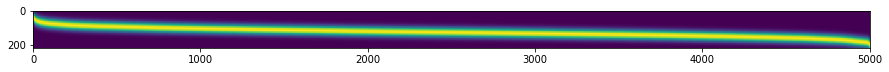

In [34]:
plt.figure(figsize=(15, 10))
plt.imshow(np.repeat(np.transpose(rmat), 10, axis=0))

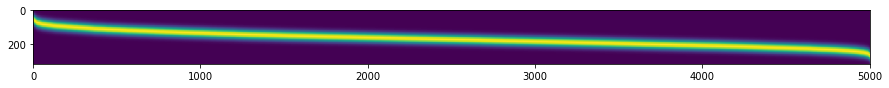

In [35]:
plt.figure(figsize=(15, 10))
plt.imshow(np.repeat(np.transpose(hmat), 10, axis=0))

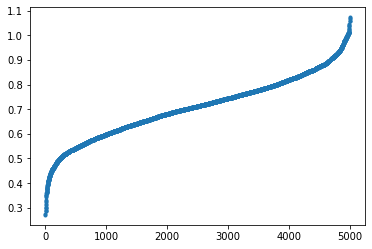

In [24]:
plt.plot(sorted(r_list), '.')

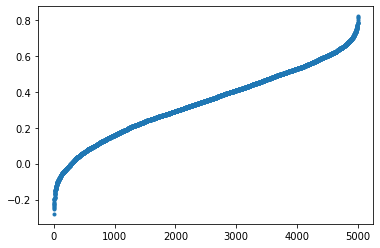

In [25]:
plt.plot(sorted(h_list), '.')

In [12]:
Rtmp = np.identity(4)
Rtmp[:3,:3] = Tref_base[:3,:3]

In [14]:
cart2cyl(*np.matmul(Rtmp[:3,:3].transpose(), Tee[:3,3]))

(0.6797316914533686, 8.476621614408802e-09, 0.5461163520812988)

In [9]:
r

0.6797316949132072

In [10]:
h

0.54611635

In [11]:
data_pairs_train = []
for data_pairs in data_pairs_train_succ:
    grasp_img, arm_img, rh_mask, label = load_data(data_pairs)
    if True: #all(label):
        data_pairs_train.append(data_pairs)
N_succ = len(data_pairs_train)
print("train set prev: {}".format(N_succ))        


for data_pairs in data_pairs_train_fails:
    grasp_img, arm_img, rh_mask, label = load_data(data_pairs)
    if False: #not all(label):
        data_pairs_train.append(data_pairs)
N_train = len(data_pairs_train)
N_fail = N_train - N_succ
print("train set new: {}".format(N_fail))
print("train set all: {}".format(N_train))

data_pairs_test = []
for data_pairs in data_pairs_test_succ:
    grasp_img, arm_img, rh_mask, label = load_data(data_pairs)
    if True: #all(label):
        data_pairs_test.append(data_pairs)
N_succ = len(data_pairs_test)
print("test set prev: {}".format(N_succ))        

for data_pairs in data_pairs_test_fails:
    grasp_img, arm_img, rh_mask, label = load_data(data_pairs)
    if False:
        data_pairs_test.append(data_pairs)
N_test = len(data_pairs_test)
N_fail = N_test - N_succ
print("test set new: {}".format(N_fail))
print("test set all: {}".format(N_test))

train set prev: 10022
train set new: 0
train set all: 10022
test set prev: 188
test set new: 0
test set all: 188


## Train

In [ ]:
from pkg.planning.filtering.lattice_model.lattice_model import *

# Create an instance of the model
model = ResNetModelTP()

loss_object = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.BinaryAccuracy(name='test_accuracy')
@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [ ]:
current_time = get_now()
logpath = os.path.join(ROBOT_MODEL_ROOT, current_time)
try_mkdir(logpath)
train_log_dir = os.path.join(logpath, 'train')
test_log_dir = os.path.join(logpath, 'test')
model_log_dir = os.path.join(logpath, 'model_{}/')
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
shutil.copy(os.path.join(PROJ_DIR,'src', 'pkg','planning','filtering','lattice_model','lattice_model.py' ), logpath)
print(f'Log path: {logpath}')

In [ ]:
EPOCHS_S = 0
EPOCHS_E = 15
BATCH_SIZE = 16
LOG_STEP = 100
N_train = len(data_pairs_train)
N_test = len(data_pairs_test)

for epoch in range(EPOCHS_S, EPOCHS_E):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
    random.shuffle(data_pairs_train)
    i_step = 0
    data_batch, label_batch = [], []
    for data_pair in data_pairs_train:
        i_step += 1
        grasp_img, arm_img, rh_mask, label = load_data(data_pair)
        data_batch.append([grasp_img, arm_img, rh_mask])
        label_batch.append(label)
        if i_step%BATCH_SIZE==0:
            grasp_img_batch = np.array([grasp_img for grasp_img, arm_img, rh_mask in data_batch])
            arm_img_batch = np.array([arm_img for grasp_img, arm_img, rh_mask in data_batch])
            rh_mask_batch = np.array([rh_mask for grasp_img, arm_img, rh_mask in data_batch])
            label_batch = np.array(label_batch, dtype=np.int)
            train_step([grasp_img_batch, arm_img_batch, rh_mask_batch], label_batch)
            data_batch, label_batch = [], []
        if i_step%LOG_STEP==0:
            print("train step - {}/{}        ".format(i_step, N_train), end = '\r')
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

    i_step = 0
    data_batch, label_batch = [], []
    for data_pair in data_pairs_test:
        i_step += 1
        grasp_img, arm_img, rh_mask, label = load_data(data_pair)
        data_batch.append([grasp_img, arm_img, rh_mask])
        label_batch.append(label)
        if i_step%BATCH_SIZE==0:
            grasp_img_batch = np.array([grasp_img for grasp_img, arm_img, rh_mask in data_batch])
            arm_img_batch = np.array([arm_img for grasp_img, arm_img, rh_mask in data_batch])
            rh_mask_batch = np.array([rh_mask for grasp_img, arm_img, rh_mask in data_batch])
            label_batch = np.array(label_batch, dtype=np.int)
            test_step([grasp_img_batch, arm_img_batch, rh_mask_batch], label_batch)
            data_batch, label_batch = [], []
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)
            
    model.save(model_log_dir.format(epoch + 1))

    print("")
    print("=================================================================")
    print(
        f'Epoch {epoch + 1}, '
        f'Loss: {train_loss.result()}, '
        f'Accuracy: {train_accuracy.result() * 100}, '
        f'Test Loss: {test_loss.result()}, '
        f'Test Accuracy: {test_accuracy.result() * 100}'
    )
    print("=================================================================")
    print("")

## New train 2021-06
* **[IMPORTANT] 이전에 Tej 사용 틀린 점 보완 했음** 

### Panda
* 20210606-210900 : Tee로 기존 데이터만 다시 학습, 큰 차이는 없음 ep6/84%
* 20210607-000553 : 새 데이터 (failmore) 1/5 포함해 학습 ep8/84.7% -> 큰 차이 없음.

### Indy7
* 20210607-232516: 기존 데이터만 학습, ep12/87.63%

## Load & test

In [12]:
print(sorted(os.listdir(ROBOT_MODEL_ROOT)))

['20210607-232516']


In [13]:
# last_model = '20210606-210900' # panda
# last_model = '20210607-232516' # indy
last_model = sorted(os.listdir(ROBOT_MODEL_ROOT))[-1]
logpath = os.path.join(ROBOT_MODEL_ROOT, last_model)

model_epoch_list = []
acc_epoch_list = []
loss_epoch_list = []
epochlist = sorted([item for item in os.listdir(logpath) if item.startswith("model")], key=lambda x: int(x[6:]))
print(epochlist)

['model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6', 'model_7', 'model_8', 'model_9', 'model_10', 'model_11', 'model_12']


In [14]:
# last_save = 'model_12' # bsorted([item for item in os.listdir(logpath) if item.startswith("model")], key=lambda x: int(x[6:]))[-1]
last_save = sorted([item for item in os.listdir(logpath) if item.startswith("model")], key=lambda x: int(x[6:]))[-1]
# last_save = 'model_1'
model_log_dir = os.path.join(logpath, last_save)


model_epoch_list = []
acc_epoch_list = []
loss_epoch_list = []

import tensorflow as tf
model = tf.keras.models.load_model(model_log_dir)

@tf.function
def inference(images):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    return predictions

loss_object = tf.keras.losses.BinaryCrossentropy()

@tf.function
def calc_loss(labels, predictions):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    return loss_object(labels, predictions)

In [16]:
dataset_list = sorted(os.listdir(ROBOT_DATA_ROOT))
DATASET_TRAIN = dataset_list[:10]
DATASET_TEST = dataset_list[10:]
print(DATASET_TRAIN)
print(DATASET_TEST)

dataset_list_fails = sorted([folder for folder in os.listdir(ROBOT_DATA_ROOT_FAILS) if not folder.startswith(".")])
DATASET_TRAIN_FAILS = dataset_list_fails[:10]
DATASET_TEST_FAILS = dataset_list_fails[10:15]
print(DATASET_TRAIN_FAILS)
print(DATASET_TEST_FAILS)

data_pairs_train_succ = []
for dataset in DATASET_TRAIN:
    file_list = sorted(os.listdir(os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER)))
    for file in file_list:
        data_pairs_train_succ.append((os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER, file), 
                                 os.path.join(ROBOT_DATA_ROOT, dataset, ARM_FOLDER, file)))
print("train set: {}".format(len(data_pairs_train_succ)))        
        
        
data_pairs_test_succ = []
for dataset in DATASET_TEST[-1:]:
    file_list = sorted(os.listdir(os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER)))
    for file in file_list:
        data_pairs_test_succ.append((os.path.join(ROBOT_DATA_ROOT, dataset, GRASP_FOLDER, file), 
                                 os.path.join(ROBOT_DATA_ROOT, dataset, ARM_FOLDER, file)))
print("test set: {}".format(len(data_pairs_test_succ)))        

data_pairs_train_fails = []
for dataset in DATASET_TRAIN_FAILS:
    file_list = sorted(os.listdir(os.path.join(ROBOT_DATA_ROOT_FAILS, dataset, GRASP_FOLDER)))
    for file in file_list:
        data_pairs_train_fails.append((os.path.join(ROBOT_DATA_ROOT_FAILS, dataset, GRASP_FOLDER, file), 
                                 os.path.join(ROBOT_DATA_ROOT_FAILS, dataset, ARM_FOLDER, file)))
print("train fail set: {}".format(len(data_pairs_train_fails)))        
        
        
data_pairs_test_fails = []
for dataset in DATASET_TEST_FAILS:
    file_list = sorted(os.listdir(os.path.join(ROBOT_DATA_ROOT_FAILS, dataset, GRASP_FOLDER)))
    for file in file_list:
        data_pairs_test_fails.append((os.path.join(ROBOT_DATA_ROOT_FAILS, dataset, GRASP_FOLDER, file), 
                                 os.path.join(ROBOT_DATA_ROOT_FAILS, dataset, ARM_FOLDER, file)))
print("test fail set: {}".format(len(data_pairs_test_fails)))        

['20210214-232708', '20210215-041031', '20210215-085110', '20210215-133753', '20210215-184319', '20210216-005455', '20210216-054418', '20210216-104554', '20210216-152114', '20210216-201729']
['20210217-010926', '20210217-063641', '20210217-113319', '20210217-162106', '20210217-205606', '20210608-122742', '20210608-194120']
['20210607-155241', '20210607-161407', '20210607-163215', '20210607-165616', '20210607-171344', '20210607-173927', '20210607-175629', '20210607-181751', '20210607-183958', '20210607-190513']
['20210607-192529', '20210607-194820', '20210607-200835', '20210607-202843', '20210607-205048']
train set: 10022
test set: 195
train fail set: 10044
test fail set: 5016


## test script

In [ ]:
def test_script():
    BATCH_SIZE = 1
    LOG_STEP = 100
    N_test = len(data_pairs_test)
    gtimer = GlobalTimer.instance()
    gtimer.reset()

    grasp_img, arm_img, rh_mask, label = load_data(data_pairs_test[0])
    res = inference([np.array([grasp_img]), np.array([arm_img]), np.array([rh_mask])])


    i_step = 0
    res_list = []
    label_list = []
    loss_list= []
    grasp_img_batch = []
    arm_img_batch = []
    rh_mask_batch = []
    label_batch = [] 
    for data_pair in data_pairs_test:
        i_step += 1
        grasp_img, arm_img, rh_mask, label = load_data(data_pair)
        grasp_img_batch.append(grasp_img)
        arm_img_batch.append(arm_img)
        rh_mask_batch.append(rh_mask)
        label_batch.append(label)
        if len(grasp_img_batch)==BATCH_SIZE:
            grasp_img_batch, arm_img_batch, rh_mask_batch = np.array(grasp_img_batch), np.array(arm_img_batch), np.array(rh_mask_batch)
            with gtimer.block("inference"):
                res = inference([grasp_img_batch, arm_img_batch, rh_mask_batch])
            loss = calc_loss(label_batch, res)
            res_list = res_list + list(res.numpy()>0.5)
            label_list = label_list + label_batch
            loss_list.append(loss.numpy())
            grasp_img_batch = []
            arm_img_batch = []
            rh_mask_batch = []
            label_batch = [] 
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')

    res_list = np.array(res_list)[:5000,1]
    label_list = np.array(label_list)[:5000,1]
    loss_list = np.array(loss_list)[:5000]

    acc = np.mean(np.equal(res_list, label_list)) * 100
    mean_loss = np.mean(loss_list)

    print("")
    print("=================================================================")
    print(
        f'Test Loss: {mean_loss} \n'
        f'Test Accuracy: {acc} \n'
        f'TP / FN / ACC: {np.sum(np.logical_and(res_list, label_list))}, ' 
        f'{np.sum(np.logical_and(np.logical_not(res_list), label_list))}, ' 
        f'{round(np.mean(res_list[np.where(label_list)])*100,2)}\n'
        f'FP / TN / ACC: {np.sum(np.logical_and(res_list, np.logical_not(label_list)))}, '
        f'{np.sum(np.logical_and(np.logical_not(res_list), np.logical_not(label_list)))}, '
        f'{round(np.mean(np.logical_not(res_list[np.where(np.logical_not(label_list))]))*100,2)}\n'
        f'PACC / NACC / TACC: {round(np.mean(label_list[np.where(res_list)])*100,2)}, '
        f'{round(np.mean(np.logical_not(label_list[np.where(np.logical_not(res_list))]))*100,2)}, '
        f'{round(np.mean(res_list==label_list)*100,2)}\n'
    )
    print("=================================================================")
    print("")
    print(gtimer)
    model_epoch_list.append(last_save)
    acc_epoch_list.append(acc)
    loss_epoch_list.append(mean_loss)

#### old data

In [17]:
data_pairs_test = []
for data_pairs in data_pairs_test_succ:
    grasp_img, arm_img, rh_mask, label = load_data(data_pairs)
    if True: #all(label):
        data_pairs_test.append(data_pairs)
N_succ = len(data_pairs_test)
print("test set prev: {}".format(N_succ))        

for data_pairs in data_pairs_test_fails:
    grasp_img, arm_img, rh_mask, label = load_data(data_pairs)
    if False: # not all(label):
        data_pairs_test.append(data_pairs)
N_test = len(data_pairs_test)
N_fail = N_test - N_succ
print("test set new: {}".format(N_fail))
print("test set all: {}".format(N_test))

test set prev: 195
test set new: 0
test set all: 195


In [18]:
test_script()

test step - 100/195        
Test Loss: 0.40208688378334045 
Test Accuracy: 84.61538461538461 
TP / FN / ACC: 139, 6, 95.86
FP / TN / ACC: 24, 26, 52.0
PACC / NACC / TACC: 85.28, 81.25, 84.62


inference: 	4808.0 ms/195 = 24.655 ms (11.648/29.51)



#### new data

In [14]:
data_pairs_test = []
for data_pairs in data_pairs_test_succ:
    grasp_img, arm_img, rh_mask, label = load_data(data_pairs)
    if False: #all(label):
        data_pairs_test.append(data_pairs)
N_succ = len(data_pairs_test)
print("test set prev: {}".format(N_succ))        

for data_pairs in data_pairs_test_fails:
    grasp_img, arm_img, rh_mask, label = load_data(data_pairs)
    if True: # not all(label):
        data_pairs_test.append(data_pairs)
N_test = len(data_pairs_test)
N_fail = N_test - N_succ
print("test set new: {}".format(N_fail))
print("test set all: {}".format(N_test))

test set prev: 0
test set new: 5016
test set all: 5016


In [15]:
test_script()

test step - 5000/5016        
Test Loss: 0.6275951266288757 
Test Accuracy: 74.44 
TP / FN / ACC: 180, 13, 93.26
FP / TN / ACC: 1265, 3542, 73.68
PACC / NACC / TACC: 12.46, 99.63, 74.44


inference: 	134013.0 ms/5016 = 26.717 ms (12.758/33.106)



#### mixed data

In [16]:
data_pairs_test = []
for data_pairs in data_pairs_test_succ:
    grasp_img, arm_img, rh_mask, label = load_data(data_pairs)
    if all(label):
        data_pairs_test.append(data_pairs)
N_succ = len(data_pairs_test)
print("test set prev: {}".format(N_succ))        

for data_pairs in data_pairs_test_fails:
    grasp_img, arm_img, rh_mask, label = load_data(data_pairs)
    if not all(label):
        data_pairs_test.append(data_pairs)
        if len(data_pairs_test) > 2*N_succ:
            break
N_test = len(data_pairs_test)
N_fail = N_test - N_succ
print("test set new: {}".format(N_fail))
print("test set all: {}".format(N_test))

test set prev: 2323
test set new: 2324
test set all: 4647


In [17]:
test_script()

test step - 4600/4647        
Test Loss: 0.49148014187812805 
Test Accuracy: 81.6655907036798 
TP / FN / ACC: 2068, 255, 89.02
FP / TN / ACC: 597, 1727, 74.31
PACC / NACC / TACC: 77.6, 87.13, 81.67


inference: 	123531.0 ms/4647 = 26.583 ms (11.217/44.391)



### old data train result - panda
* old data
```
Test Loss: 0.3710089325904846 
Test Accuracy: 84.11999999999999 
TP / FN / ACC: 2567, 358, 87.76
FP / TN / ACC: 436, 1639, 78.99
PACC / NACC / TACC: 85.48, 82.07, 84.12
```
* new data
```
Test Loss: 0.4806087017059326 
Test Accuracy: 80.58 
TP / FN / ACC: 165, 16, 91.16
FP / TN / ACC: 955, 3864, 80.18
PACC / NACC / TACC: 14.73, 99.59, 80.58
```
* balanced data
```
Test Loss: 0.37245243787765503 
Test Accuracy: 85.06 
TP / FN / ACC: 2567, 361, 87.67
FP / TN / ACC: 386, 1686, 81.37
PACC / NACC / TACC: 86.93, 82.36, 85.06
```

### old data train result - indy7
* old data
```
Test Loss: 0.3250460922718048 
Test Accuracy: 87.24 
TP / FN / ACC: 2068, 255, 89.02
FP / TN / ACC: 383, 2294, 85.69
PACC / NACC / TACC: 84.37, 90.0, 87.24
```
* new data
```
Test Loss: 0.6275951266288757 
Test Accuracy: 74.44 
TP / FN / ACC: 180, 13, 93.26
FP / TN / ACC: 1265, 3542, 73.68
PACC / NACC / TACC: 12.46, 99.63, 74.44
```
* balanced data
```
Test Loss: 0.49148014187812805 
Test Accuracy: 81.6655907036798 
TP / FN / ACC: 2068, 255, 89.02
FP / TN / ACC: 597, 1727, 74.31
PACC / NACC / TACC: 77.6, 87.13, 81.67
```

### 1/5 mixed train result - panda
* new data
```
Test Loss: 0.0880737230181694 
Test Accuracy: 96.6 
TP / FN / ACC: 138, 43, 76.24
FP / TN / ACC: 127, 4692, 97.36
PACC / NACC / TACC: 52.08, 99.09, 96.6
```
  - Positive GT에 대한 정확도가 오히려 감소함!

## Test convergence

In [ ]:
last_model = sorted(os.listdir(ROBOT_MODEL_ROOT))[-1]
logpath = os.path.join(ROBOT_MODEL_ROOT, last_model)

model_epoch_list = []
acc_epoch_list = []
loss_epoch_list = []
# last_save = sorted([item for item in os.listdir(logpath) if item.startswith("model")])[-1]
# last_save = 'model_1'
for last_save in sorted([item for item in os.listdir(logpath) if item.startswith("model")], key=lambda x: int(x[6:])):
    model_log_dir = os.path.join(logpath, last_save)

    import tensorflow as tf
    model = tf.keras.models.load_model(model_log_dir)

    @tf.function
    def inference(images):
        # training=False is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=False)
        return predictions

    loss_object = tf.keras.losses.BinaryCrossentropy()

    @tf.function
    def calc_loss(labels, predictions):
        # training=False is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        return loss_object(labels, predictions)
    
    BATCH_SIZE = 50
    LOG_STEP = 100
    N_test = len(data_pairs_test)
    gtimer = GlobalTimer.instance()
    gtimer.reset()

    i_step = 0
    res_list = []
    label_list = []
    loss_list= []
    grasp_img_batch = []
    arm_img_batch = []
    rh_mask_batch = []
    label_batch = [] 
    for data_pair in data_pairs_test:
        i_step += 1
        grasp_img, arm_img, rh_mask, label = load_data(data_pair)
        grasp_img_batch.append(grasp_img)
        arm_img_batch.append(arm_img)
        rh_mask_batch.append(rh_mask)
        label_batch.append(label)
        if len(grasp_img_batch)==BATCH_SIZE:
            grasp_img_batch, arm_img_batch, rh_mask_batch = np.array(grasp_img_batch), np.array(arm_img_batch), np.array(rh_mask_batch)
            with gtimer.block("inference"):
                res = inference([grasp_img_batch, arm_img_batch, rh_mask_batch])
            loss = calc_loss(label_batch, res)
            res_list = res_list + list(res.numpy()>0.5)
            label_list = label_list + label_batch
            loss_list.append(loss.numpy())
            grasp_img_batch = []
            arm_img_batch = []
            rh_mask_batch = []
            label_batch = [] 
        if i_step%LOG_STEP==0:
            print("test step - {}/{}        ".format(i_step, N_test), end = '\r')

    res_list = np.array(res_list)[:5000,1]
    label_list = np.array(label_list)[:5000,1]
    loss_list = np.array(loss_list)[:5000]
    
    acc = np.mean(np.equal(res_list, label_list)) * 100
    mean_loss = np.mean(loss_list)

    print("")
    print("=================================================================")
    print(
        f'Test Loss: {mean_loss} \n'
        f'Test Accuracy: {acc} \n'
        f'TP / FN / ACC: {np.sum(np.logical_and(res_list, label_list))}, ' 
        f'{np.sum(np.logical_and(np.logical_not(res_list), label_list))}, ' 
        f'{round(np.mean(res_list[np.where(label_list)])*100,2)}\n'
        f'FP / TN / ACC: {np.sum(np.logical_and(res_list, np.logical_not(label_list)))}, '
        f'{np.sum(np.logical_and(np.logical_not(res_list), np.logical_not(label_list)))}, '
        f'{round(np.mean(np.logical_not(res_list[np.where(np.logical_not(label_list))]))*100,2)}\n'
        f'PACC / NACC / TACC: {round(np.mean(label_list[np.where(res_list)])*100,2)}, '
        f'{round(np.mean(np.logical_not(label_list[np.where(np.logical_not(res_list))]))*100,2)}, '
        f'{round(np.mean(res_list==label_list)*100,2)}\n'
    )
    print("=================================================================")
    print("")
    print(gtimer)
    model_epoch_list.append(last_save)
    acc_epoch_list.append(acc)
    loss_epoch_list.append(mean_loss)

In [ ]:
import matplotlib.pyplot as plt
print(model_epoch_list)
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot(acc_epoch_list)
plt.subplot(1,2,2)
plt.plot(loss_epoch_list)

In [ ]:
save_json(ROBOT_TYPE_NAME+".json", {"epoch": np.array(model_epoch_list), "acc": np.array(acc_epoch_list), "loss": np.array(loss_epoch_list)})

## test on shared array

In [ ]:
import SharedArray as sa
BATCH_SIZE = 1
SERVER_PERIOD = 1e-2
# Create an array in shared memory.
robot_type_p = sa.attach("shm://robot_type")
grasp_img_p = sa.attach("shm://grasp_img")
arm_img_p = sa.attach("shm://arm_img")
rh_mask_p = sa.attach("shm://rh_mask")
result_p = sa.attach("shm://result")
query_in = sa.attach("shm://query_in")
response_out = sa.attach("shm://response_out")
query_quit = sa.attach("shm://query_quit")

def query_wait_response(grasp_img_batch, arm_img_batch, rh_mask_batch):
    grasp_img_p[:] = grasp_img_batch[:]
    arm_img_p[:] = arm_img_batch[:]
    rh_mask_p[:] = rh_mask_batch[:]
    query_in[0] = True
    while not response_out[0]:
        time.sleep(SERVER_PERIOD)
    response_out[0] = False
    return np.copy(result_p)

def quit_shared_server():
    query_quit[0] = True

In [ ]:
LOG_STEP = 100
N_test = len(data_pairs_test)

i_step = 0
data_batch, label_batch = [], []
result_list = []
label_list = []
for data_pair in data_pairs_test:
    i_step += 1
    grasp_img, arm_img, rh_mask, label = load_data(data_pair)
    data_batch.append([grasp_img, arm_img, rh_mask])
    label_batch.append(label)
    if i_step%BATCH_SIZE==0:
        grasp_img_batch = np.array([grasp_img for grasp_img, arm_img, rh_mask in data_batch])
        arm_img_batch = np.array([arm_img for grasp_img, arm_img, rh_mask in data_batch])
        rh_mask_batch = np.array([rh_mask for grasp_img, arm_img, rh_mask in data_batch])
        label_batch = np.array(label_batch, dtype=np.int)
        result = query_wait_response(grasp_img_batch, arm_img_batch, rh_mask_batch)
        result_list.append(result)
        label_list.append(label_batch)
        data_batch, label_batch = [], []
    if i_step%LOG_STEP==0:
        print("test step - {}/{}        ".format(i_step, N_test), end = '\r')

In [ ]:
result_all = np.array(result_list)
label_all = np.array(label_list)

In [ ]:
np.mean(np.round(result_all).astype(np.int) == label_all.astype(np.int), axis=0)

In [ ]:
quit_shared_server()

## save gridded data

In [ ]:
data_pair = data_pairs_test[0]
grasp_data = load_pickle(data_pair[0])
arm_data = load_pickle(data_pair[1])
grasp_tar_idx = grasp_data[b'tar']
grasp_tool_idx = grasp_data[b'tool']
arm_tar_idx = arm_data[b'tar']
Tee = grasp_data[b'T_end_effector']
Tej = grasp_data[b'T_end_joint']
Tref_base = grasp_data[b'Tref_base']
reach_lb = grasp_data[b'reach']
retrieve_lb = grasp_data[b'retrieve']
r, th, h = cart2cyl(*Tee[:3,3])
r_ej, th, h_ej = cart2cyl(*Tej[:3,3])
r_class = div_r(r_ej)
h_class = div_h(h_ej)
r_mask = np.zeros(RH_MASK_SIZE)
r_mask[r_class*RH_MASK_STEP:r_class*RH_MASK_STEP+RH_MASK_STEP] = 1
h_mask = np.zeros(RH_MASK_SIZE)
h_mask[h_class*RH_MASK_STEP:h_class*RH_MASK_STEP+RH_MASK_STEP] = 1
rh_mask = np.concatenate([r_mask, h_mask])
# r_ej_list.append(r_ej)
# h_ej_list.append(h_ej)
# reach_lb_list.append(reach_lb)
Tref = SE3(Rot_axis(3, th), Tee[:3,3])
grasp_tool_img = np.zeros(GRASP_SHAPE)
grasp_tar_img = np.zeros(GRASP_SHAPE)
grasp_tool_img[np.unravel_index(grasp_tool_idx, shape=GRASP_SHAPE)] = 1
grasp_tar_img[np.unravel_index(grasp_tar_idx, shape=GRASP_SHAPE)] = 1
arm_img = np.zeros(ARM_SHAPE+(1,))
arm_img[np.unravel_index(arm_tar_idx, shape=ARM_SHAPE)] = 1
grasp_img = np.stack([grasp_tool_img, grasp_tar_img], axis=-1)

In [ ]:
# save_json("tar_arm.json", np.array(np.unravel_index(arm_tar_idx, shape=ARM_SHAPE)).transpose())

In [ ]:
# save_json("tool_effector.json", np.array(np.unravel_index(grasp_tool_idx, shape=GRASP_SHAPE)).transpose())
# save_json("tar_effector.json", np.array(np.unravel_index(grasp_tar_idx, shape=GRASP_SHAPE)).transpose())

## visualize r, h class distribution

In [ ]:
import matplotlib.pyplot as plt
r_ej_list = []
h_ej_list = []
for data_pair in data_pairs_train:
    grasp_data = load_pickle(data_pair[0])
    arm_data = load_pickle(data_pair[1])
    grasp_obj_idx = grasp_data[b'obj']
    grasp_tar_idx = grasp_data[b'tar']
    grasp_tool_idx = grasp_data[b'tool']
    arm_tar_idx = arm_data[b'tar']
    Tee = grasp_data[b'T_end_effector']
    Tej = grasp_data[b'T_end_joint']
    Tref_base = grasp_data[b'Tref_base']
    reach_lb = grasp_data[b'reach']
    retrieve_lb = grasp_data[b'retrieve']
    r, th, h = cart2cyl(*Tee[:3,3])
    r_ej, th, h_ej = cart2cyl(*Tej[:3,3])
    r_ej_list.append(r_ej)
    h_ej_list.append(h_ej)

In [ ]:
def div_r(r):
    return floor(sigmoid((r)/0.1-7)*8)

def div_h(h):
    return floor(sigmoid((h+0.6)/0.2-5)*8)

In [ ]:
plt.subplot(1,2,1)
plt.plot(sorted([div_r(r_ej_) for r_ej_ in r_ej_list]), '.')
plt.subplot(1,2,2)
plt.plot(sorted([div_h(h_ej_) for h_ej_ in h_ej_list]), '.')

In [ ]:
plt.subplot(1,2,1)
plt.plot(sorted([div_r(r_ej_) for r_ej_ in r_ej_list]), '.')
plt.subplot(1,2,2)
plt.plot(sorted([div_h(h_ej_) for h_ej_ in h_ej_list]), '.')

In [ ]:

plt.plot(sorted(np.floor(np.divide(r_ej_list,0.1))), '.')
plt.plot(sorted(np.floor(np.divide(h_ej_list,0.1))), '.')

In [ ]:

plt.plot(sorted(r_ej_list), '.')
plt.plot(sorted(h_ej_list), '.')

In [ ]:
np.max(r_ej_list)

In [ ]:
1.0 - 0.2

In [ ]:
np.min((np.array(r_ej_list)-0.2))

In [ ]:
np.min(np.floor((np.array(r_ej_list)-0.2)/0.05).astype(np.int))

In [ ]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

In [ ]:
x = div_r_gaussian(sorted(r_ej_list)[5000])

In [ ]:
y = div_h_gaussian(sorted(h_ej_list)[5000])

In [ ]:
plt.figure(figsize=(11,5))
plt.imshow(x[np.newaxis, :], cmap='gray')

In [ ]:
plt.figure(figsize=(16,5))
plt.imshow(y[np.newaxis, :], cmap='gray')

In [ ]:
def div_h_gaussian(h_val):
    return gaussian(h_val, np.arange(-0.5,1.1, 0.05),0.05)

In [ ]:

def div_h(h):
    return floor(sigmoid((h+0.6)/0.2-4.5)*8)

In [ ]:
X = np.repeat(np.transpose([div_r_gaussian(r_val) for r_val in sorted(r_ej_list)]), 100, axis=0)

In [ ]:
X = np.repeat(np.transpose([div_h_gaussian(h_val) for h_val in sorted(h_ej_list)]), 100, axis=0)

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(X)

In [ ]:
min(r_ej_list), max(r_ej_list)

In [ ]:
min(h_ej_list), max(h_ej_list)

In [ ]:
plt.plot(sorted(np.clip(np.floor((np.array(r_ej_list)-0.2)/0.05).astype(np.int), 0, 15)))

In [ ]:
Ndat = len(data_pairs_train)
sorted(r_ej_list)